
This repository is a tutorial dedicated to create a ML agent that can play chess in FHE using the Concrete-ML library. This work also [compete for a bounty program](https://github.com/zama-ai/bounty-program/blob/main/Bounties/Machine_Learning/create-an-app-play-chess-in-fhe.md).

# Problem description

Before digging into the code, we need to understand what the FHE means and how this will impact our model.

By using FHE, a user will first, locally, crypted a board of a chess game. This crypted data, will then be send to a server where an AI agent will play his turn. In this configuration, the server and the agent will receive a encrypted data. However, the server will not be able to understand the logic of it, but the agent does. Therefore, the IA agent will get this data, use it as an input and get back a move. This move will be encrypted and sent it back to the user, that can read and apply the agent move.

Through this constraint, we are limited in the proposed algorithm/model. As you may have already know, existing chess algorithm usually given a board, try to maximize the gain through the next possible moves. So, given a position, an algorithm will first generate all the position based on the possible moves, iterate over them, compute a score indicating if the move is good or not and choose the one that optimize the score of winning. However, the data sent are crypted. So, we do not know the position of the current model. Thus, we cannot guess what will be the possible movement allowed. Indeed, by using a ML agent, it can produce a move that seems legit but is not, as it does not know the rule of chess.


## First approach

Knowing those constraints, we decided to think about a simple approach that takes an encrypted board and generate as output a single move encrypted. 


### Board representation

In the chess game, we have two opponents the black and the white. The objective is to checkmate the opponent's king. To play this game, we have a board of 8 x 8 square. Each team have multiples pieces: 1 king, 1 queen, 2 rooks 2 bishops, 2 knights and 8 pawns. At the beginning of a game, the white starts by playing a move, then it is the turn of the black, and so on... Until one king is checkmate. 

Given those information, we can think about a board representation that can be use for our deep learning model. Our input data will be a matrix of 8 by 8. To represent the pieces on the board, we can simply think about a one-hot encoding representation, where each team's pieces will have its own representation. So we will have 13 encoding representation (the 12 pieces and the empty square). So our input shape will be 12x8x8 (Note: here we only use 12 as the empty one will be only 0).

This encoded board can then be use as input in our deep learning model. Now, we need to think about the output representation of our model, that is how our model will give us the next move.


### Predict the next move

To predict a next move, we need to think about two things: the piece that we want to move and the position where we want to move that piece. The position can be describe as two coordinates: one for the row and one for the columns.

In our first implementation, we decided to see this problem as a classification one. Thus, at the end of our model, we will have three branches: 
- one for predicting the piece : We will have 12 possibilities
- one for the row index : 8 
- one for the column index : 8




that allow us to get the encrypted data and get out a single move. In our case, we will pass a board of chess and our model will generate a single move.

A possibility is to have a single model that take in input chess board, and generate as an output the possible best move. By using this approach, we set some hypothesis. First, the board send by the client is valid. second the move generated by the agent will also be valid 








### Hypothesis

To simplify our first implementation, multiple hypothesis have been done.

#### Invalid moves

First, the predicting move of our model can be an invalid one. Indeed, our deep learning model do not know exactly the possible moves on a chess board. It is possible that a well trained model learn implicitaly the rules of chess, but it is not hard coded. Thus, given a board, the model will output a move that is valid or not. 

In state of the art implementation, given a chess board, we generate all possible moves that are valid. Then, we iterate over them and evaluate them using a deep learning model. Finally, we take the move that maximize the score for the given player.

However, in FHE, this approach is limited. Indeed, we cannot, given a chess board, send all the possible moves. Event if the moves are encrypted, this can still be used to determine the board position given the possible moves. To counteract this issue, a possible solution could be to build a list of candidates moves. We will send to the model a fixed list encrypted of moves with a length equal to the maximum number of positions playable in chess. Thus, we will fill the list with the possibles moves, but also with some dummy/empty entries.

This approach allows us to be sure that the generated moves will be a legal one. However, this approach is more costly as we need to send a large number of moves to be evaluated. Also, the user side should play fair as he will be the one to generate the candidates moves.

#### The AI do not know his team

In our first implementation, the AI does not know his team. Currently, we just want to know if our deep learning model can learn some moves and if our model can work in FHE. In future version, we will complexify our inputs to manage that issue. 

A solution for that could be to add an additional feature telling us which color team it is. 


#### No complex move

In chess, special moves exist: casting, promotion and en passant. In our first implementation, we will not focus our attention on those moves. It could be an improvment of our model implementation in the future. Regarding the promotion it will be always be a queen at the moment.


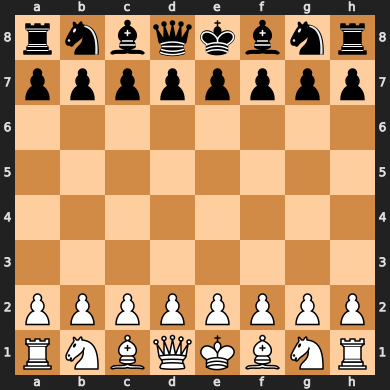

In [42]:
import chess
chess.Board()



# Get the data


First of all, for all Deep Learning project, we need data. We will use the lichess open librairy 
> https://database.lichess.org/#standard_games

We will have some data `.pgn.zst`. You can first decompress the data. (Note: the output file can be huge).
Then, we need to export the data in an easy way to extract them. For that, we use the `PGNData` library. 

> Note: The library does not manage huge file, it is intereting to take a sample of it and then apply the export on it.

After this treatment, we obtain at the end two files. One entitled `_moves.csv` and the other `_game_info.csv`. The `_game_info.csv` file gives us information about the metadata of the game. This is where we will access the metadata. Whereas, `_moves.csv` contains the moves sequence for the game.  


```python
from converter.pgn_data import PGNData

FILE_NAME = "lichess_db_standard_rated_2023-01.pgn"

pgn_data = PGNData(FILE_NAME)
pgn_data.export()
```

We decided to extract the game with an elo above 1500. We then extract the board, the next move and the piece use for this board. We gather this information in a single csv file. You can see a quick view bellow:

> Note: other dataset available here: https://www.kaggle.com/datasets/arevel/chess-games


TODO :: https://www.youtube.com/watch?v=aOwvRvTPQrs

In [43]:
# %pip install chess --quiet
# %pip install concrete-ml --quiet
# %pip install brevitas --quiet
# %pip install scikit-learn --quiet

In [44]:
import os

from tqdm import tqdm_notebook as tqdm

import chess
import time

import re

import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.optim import Adam 


import pytorch_lightning as pl

from torchmetrics import Accuracy


from sklearn.model_selection import train_test_split

import brevitas.nn as qnn

from torch.utils.data import DataLoader



In [82]:
# Hyperparameters
TRAINING = True

FHE_MODE = 0        # 0 -> simulate 

In [46]:
df = pd.read_csv("./data/samples_data.csv")
df.head()

,Unnamed: 0,to_square,piece,move_sequence,before_board,after_board,white_turn
0,0,b3,P,b3,r n b q k b n r\np p p p p p p p\n. . . . . . ...,r n b q k b n r\np p p p p p p p\n. . . . . . ...,True
1,1,e6,P,b3|e6,r n b q k b n r\np p p p p p p p\n. . . . . . ...,r n b q k b n r\np p p p . p p p\n. . . . p . ...,False
2,2,b2,B,b3|e6|Bb2,r n b q k b n r\np p p p . p p p\n. . . . p . ...,r n b q k b n r\np p p p . p p p\n. . . . p . ...,True
3,3,e7,Q,b3|e6|Bb2|Qe7,r n b q k b n r\np p p p . p p p\n. . . . p . ...,r n b . k b n r\np p p p q p p p\n. . . . p . ...,False
4,4,g4,P,b3|e6|Bb2|Qe7|g4,r n b . k b n r\np p p p q p p p\n. . . . p . ...,r n b . k b n r\np p p p q p p p\n. . . . p . ...,True


In [47]:
def encode_piece(board: str, piece_type: str):
    # Select only the piece and assign an id based on the color
    board = re.sub(f"[^{piece_type}{piece_type.upper()} \n]", ".", board)
    board = re.sub(f"{piece_type}", "-1", board)
    board = re.sub(f"{piece_type.upper()}", "1", board)
    board = re.sub("\.", "0", board)
    
    # Transform our string board to a matrix
    matrix = [[int(char) for char in line.split(' ')] for line in board.splitlines()]
    
    return np.array(matrix)

def board_encoding(board: str, white_turn: bool) -> np.array:
    enc_board = np.stack([
        encode_piece(board, "k"),
        encode_piece(board, "q"),
        encode_piece(board, "r"),
        encode_piece(board, "b"),
        encode_piece(board, "n"),
        encode_piece(board, "p")
    ])
    if not white_turn:
        enc_board *= -1
    return enc_board

In [48]:
# Board encoding
item = df.iloc[0]
board_encoding(item["before_board"], True).shape

(6, 8, 8)

In [49]:
# Compute one hot encoding for letter column
column_letters = "abcdefgh"
chess_columns = {column_letters[i]:[int(j == i) for j in range(len(column_letters))] for i in range(len(column_letters))}

# Compute one hot encoding for row
row_letters = "12345678"
chess_rows = {row_letters[i]:[int(j == i) for j in range(len(row_letters))] for i in range(len(row_letters))}


# Change our model approach
def from_to_array(before, after, move: str):

    column_letters = "abcdefgh"
    row_letters    = "87654321"

    # letter, number
    ith_column, ith_row = move[0], move[1]
    ith_column = int(column_letters.index(ith_column))
    ith_row    = int(row_letters.index(ith_row))

    mask_after = np.zeros((8, 8), dtype=bool)
    mask_after[ith_row, ith_column] = True

    before_decod = [line.split(' ') for line in before.splitlines()]
    after_decod  = [line.split(' ') for line in after.splitlines()]

    changes = np.array(np.array(before_decod) != np.array(after_decod), dtype=bool) 
    
    from_array = changes ^ mask_after
    to_array   = changes & mask_after

    return from_array, to_array


In [50]:
item = df.iloc[0]
print(item["to_square"])
print(chess_columns[item["to_square"][0]])
print(chess_rows[item["to_square"][1]])

b3
[0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0]


In [51]:
class ChessDataset(Dataset):
    def __init__(self, csv_file: str):
        self.df = pd.read_csv(csv_file)
        
        self.df["target_column"] = self.df["to_square"].apply(lambda x: x[0])
        self.df["target_row"]    = self.df["to_square"].apply(lambda x: x[1])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        data = self.df.iloc[idx]

        # Get the board before the move and by setting it with the color
        X = board_encoding(data["before_board"], data["white_turn"])
        
        # Get the piece position that moving
        # y_from, y_to = from_to_array(data["before_board"], data["after_board"], data["to_square"])
        
        row, column = (
            np.array(chess_rows[data["target_row"]]),
            np.array(chess_columns[data["target_column"]])
        )
         
        return torch.tensor(X).type(torch.FloatTensor), (
            torch.tensor(row).type(torch.FloatTensor), 
            torch.tensor(column).type(torch.FloatTensor)
        )


In [52]:
training_chess = ChessDataset("./data/samples_data.csv")

data_calibration, y_callibration = next(iter(training_chess))
print("Training data shape:", data_calibration.shape)
print("Output training shape:", y_callibration[0].shape, y_callibration[1].shape)

Training data shape: torch.Size([6, 8, 8])
Output training shape: torch.Size([8]) torch.Size([8])


In [53]:
# item = df.iloc[0]
# y_from, y_to = from_to_array(item["before_board"], item["after_board"], item["to_square"])
# torch.tensor(y_from).type(torch.FloatTensor)

## Model Implementation

For the model, we based our approach with a convolutional network. As explained in the introduction, we have an input matrix of 12x8x8. We can see the board as an image. And for dealing with images, convolutional network works the best.



---------

We avoid using maxpooling

Single output as currently concrete-ml do not manage multiple output. 
Thus, we get a single vector that we reshape to decompose it in three.

---------


In [54]:
class ConvModel(pl.LightningModule):
    """Deep Convolutional Model.

    Note: In FHE, MaxPooling operations are quite slow in FHE.
    It's better to replace them by using AveragePooling instead,
    if it doesn't drop the accuracy of the model.
    """    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6, 12, kernel_size=(3,3), stride=1, padding=1)
        self.act1  = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(12, 36, kernel_size=(3,3), stride=1, padding=1)
        self.act2  = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=(2, 2))
        
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(144, 64)
        self.act3 = nn.ReLU()

        self.out = nn.Linear(64, 8+8)

        self.criterion1 = nn.CrossEntropyLoss()
        self.criterion2 = nn.CrossEntropyLoss()
        
        self.metric_row = Accuracy(task="binary")
        self.metric_col = Accuracy(task="binary")
 
    def forward(self, x):
        
        x = self.act1(self.conv1(x))
        x = self.pool1(x)

        x = self.act2(self.conv2(x))
        x = self.pool2(x)

        x = self.flat(x)
        x = self.act3(self.fc3(x))
                
        return self.out(x)

    def configure_optimizers(self):
        return Adam(self.parameters())
    
    def compute_loss_and_accuracy(self, batch, training = False):

        x, (y_row, y_col) = batch

        # Do the prediction
        y_pred = self(x)

        # Get the row and col predictions
        pred_row, pred_col = torch.split(y_pred, [8, 8], dim=1)
        
        # Compute the loss
        loss_1 = self.criterion1(pred_row, y_row)
        loss_2 = self.criterion2(pred_col, y_col)
        loss   = loss_1 + loss_2

        # Accuracy metrics
        accuracy_row = self.metric_row(pred_row, y_row)
        accuracy_col = self.metric_col(pred_col, y_col)

        # Log
        if training:
            self.log('train_loss', loss, prog_bar=True)
        self.log('train_accuracy_row', accuracy_row, prog_bar=True)
        self.log('train_accuracy_col', accuracy_col, prog_bar=True)

        return loss, (accuracy_row, accuracy_col)


    def training_step(self, train_batch, batch_idx):
        loss, _ = self.compute_loss_and_accuracy(train_batch, training=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        _, (accuracy_row, accuracy_col) = self.compute_loss_and_accuracy(val_batch)
        return (accuracy_row, accuracy_col)

For the training of our deep learning model, we split our data into training and validation sets.

In [55]:
def data_train_test_split(filename: str) -> tuple[str, str]:
    train_filename = "/tmp/train.csv"
    test_filename = "/tmp/test.csv"

    df = pd.read_csv(filename)
    train, test = train_test_split(df, test_size=0.2)
    train.to_csv(train_filename)
    test.to_csv(test_filename)

    return train_filename, test_filename

In [56]:
train, test = data_train_test_split("./data/samples_data.csv")

training_chess = ChessDataset(train)
testing_chess  = ChessDataset(test)

batch_size   = 32
train_loader = DataLoader(training_chess, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader   = DataLoader(testing_chess, batch_size=batch_size, num_workers=6)

model = ConvModel()

## Model construction 

A board can be seen as a matrix.



Note: In FHE, MaxPooling operations are quite slow in FHE.
    It's better to replace them by using AveragePooling instead,
    if it doesn't drop the accuracy of the model.

In [57]:
ConvModel()

ConvModel(
  (conv1): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (conv2): Conv2d(12, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=144, out_features=64, bias=True)
  (act3): ReLU()
  (out): Linear(in_features=64, out_features=16, bias=True)
  (criterion1): CrossEntropyLoss()
  (criterion2): CrossEntropyLoss()
  (metric_row): BinaryAccuracy()
  (metric_col): BinaryAccuracy()
)

Description of the input

In [58]:
y_callibration[0][1].shape

torch.Size([])

In [59]:
training_chess = ChessDataset("./data/samples_data.csv")

data_calibration, y_callibration = next(iter(training_chess))
print("Training data shape:", data_calibration.shape)

print("Output training shape:", y_callibration[0].shape, y_callibration[1].shape)

Training data shape: torch.Size([6, 8, 8])
Output training shape: torch.Size([8]) torch.Size([8])


In [60]:
y_callibration


m = ConvModel()



# y_pred[0].shape

# data_calibration = data_calibration #.unsqueeze(0).shape
y_pred = m(data_calibration)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (36x4 and 144x64)

In [61]:
if TRAINING or not os.path.exists("./model/model_weights.pt"):
    trainer = pl.Trainer(max_epochs=5, accelerator='cpu')
    trainer.fit(model, train_loader, val_loader)
    torch.save(model.state_dict(), "./model/model_weights.pt")
else:
    model = ConvModel()
    model.load_state_dict(torch.load("./model/model_weights.pt"))

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rere/Project/PlayChessFHE/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

   | Name       | Type             | Params
-------------------------------------------------
0  | conv1      | Conv2d           | 660   
1  | act1       | ReLU             | 0     
2  | pool1      | AvgPool2d        | 0     
3  | conv2      | Conv2d           | 3.9 K 
4  | act2       | ReLU             | 0     
5  | pool2      | AvgPool2d        | 0     
6  | flat       | Flatten          | 0     
7  | fc3        | Linear           | 9.3 K 
8  | act3       | ReLU             | 0     
9  | out        | Linear           | 1.0 K 
10 | criterion1 | CrossEntropyLoss | 0     
11 | criterion2

Epoch 4: 100%|██████████| 4582/4582 [00:57<00:00, 79.41it/s, v_num=91, train_loss=3.560, train_accuracy_row=0.648, train_accuracy_col=0.676, train_accuracy_before=0.652, train_accuracy_after=0.650] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 4582/4582 [00:57<00:00, 79.40it/s, v_num=91, train_loss=3.560, train_accuracy_row=0.648, train_accuracy_col=0.676, train_accuracy_before=0.652, train_accuracy_after=0.650]


## Test our model

e4


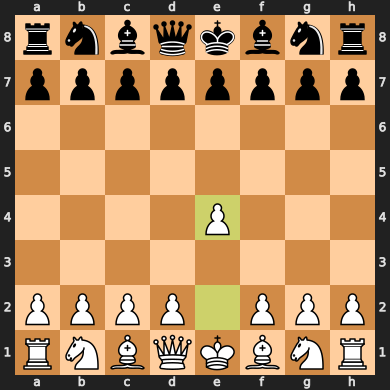

e5


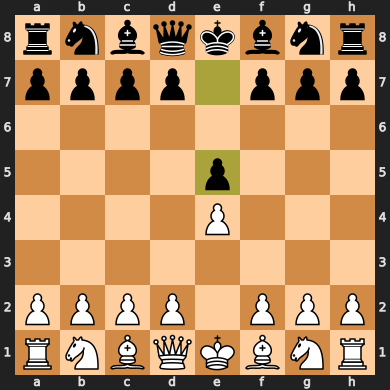

f3


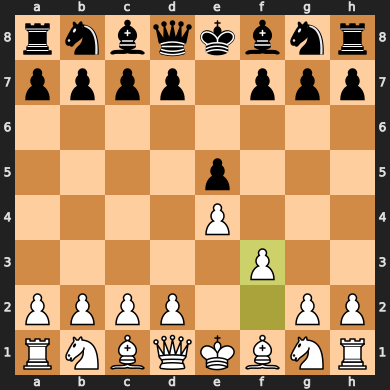

c6


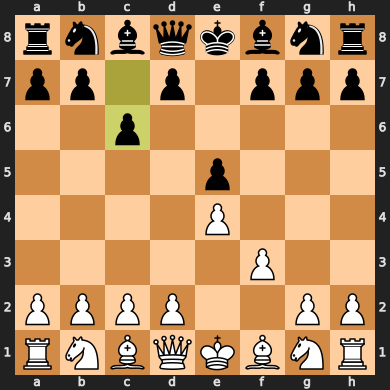

In [69]:

model.eval()
game_chess = chess.Board()

white_turn = True

for i in range(4):
    # Computer turn
    input_board = board_encoding(str(game_chess), white_turn)

    input_board = torch.tensor(input_board).type(torch.FloatTensor)
    input_board = input_board.unsqueeze(0)

    y_pred = model(input_board)

    pred_row, pred_col = torch.split(y_pred, [8, 8], dim=1)

    pred_row = torch.argmax(pred_row, dim=1).item()
    pred_col = torch.argmax(pred_col, dim=1).item()

    move = column_letters[pred_col] + row_letters[pred_row]
    print(move)
    
    game_chess.push_san(move)
    display(game_chess)

    white_turn = not white_turn
    

# Run our model in FHE

## Compile our model to concreteML

Concrete ML implements model inference using Concrete as a backend. In order to execute in FHE, a numerical program written in Concrete needs to be compiled. 

The compilation process can be decomposed into three phases:

- Tracing the NumPy program and creating a Concrete op-graph
- Checking the op-graph for FHE compatability
- Producing machine code for the op-graph (determines cryptograpgic parameters)

For debugging purposes, it can be interesting to run ou model in FHE simulation. Indeed, by doing the first step, we can execute the op-graph on clear non-encrypted data allowing us to check quickly our model, as it is much faster than executing in FHE. Also, it can allow us to check the impact of the bit-widhts of our model layer using on FHE execution.

> More info: https://docs.zama.ai/concrete-ml/advanced-topics/compilation


Compilation of a model produces machine code that executes the model on encrypted data. In some cases, notably in the client/server setting, the compilation can be done by the server when loading the model for serving.


> https://docs.zama.ai/concrete-ml/developer-guide/inner-workings/fhe-op-graphs


> Quick overview of FHE: https://www.youtube.com/watch?v=orhloWLxmA0


> Pitch https://www.youtube.com/watch?v=polCbdExQH8



The maximum bitwidth used in your model, accessible via compiled_model.fhe_circuit.graph.maximum_integer_bit_width(). If this number is more than 8 bits, you're in the worse case scenario for the precision. You can check which layers use the most bitwidth by printing compiled_model.fhe_circuit. You mentioned that your model uses 8 bits quantization for both weights and activation. I am surprised that this compiles to FHE considering the current 16-bit limitation of FHE. If you want to lower the precision withou damaging the accuracy, I'd recommend training your model using Brevitas (https://docs.zama.ai/concrete-ml/developer-guide/inner-workings/external_libraries#brevitas), defining the weights and activation to be 4 bits.

Finally, p_error can be a useful tool to speed up FHE execution. Be aware, though, that setting this too high can significantly affect accuracy. Concrete-ML provides a way for you to find the best p_error for your model, which you can find here: https://docs.zama.ai/concrete-ml/advanced-topics/advanced_features#searching-for-the-best-error-probability.


In [70]:
from concrete.ml.torch.compile import compile_torch_model

train_loader = DataLoader(training_chess, batch_size=1, shuffle=True, num_workers=1)

data_calibration, _ = next(iter(train_loader))
#data_calibration = data_calibration[0]

n_bits_qat = 4

fhe_model = compile_torch_model(
    model, 
    data_calibration, 
    n_bits = n_bits_qat,
    p_error=0.1  
) #, import_qat=True, n_bits=n_bits_qat)

# p_error=0.1)


In [71]:
fhe_model.bitwidth_and_range_report()

{'/conv1/Conv': {'range': (-70, 84), 'bitwidth': 8},
 '/pool1/AveragePool': {'range': (0, 28), 'bitwidth': 5},
 '/conv2/Conv': {'range': (-166, 46), 'bitwidth': 9},
 '/pool2/AveragePool': {'range': (0, 54), 'bitwidth': 6},
 '/fc3/Gemm': {'range': (-362, 157), 'bitwidth': 10},
 '/out/Gemm': {'range': (-52, 38), 'bitwidth': 7}}

## Optimization notes


#### Setting the error

Concrete ML makes use of table lookups (TLUs) to represent any non-linear operation (e.g., a sigmoid). TLUs are implemented through the Programmable Bootstrapping (PBS) operation, which applies a non-linear operation in the cryptographic realm. The result of TLU operations is obtained with a specific error probability. Concrete ML offers the possibility to set this error probability, which influences the cryptographic parameters. The higher the success rate, the more restrictive the parameters become. This can affect both key generation and, more significantly, FHE execution time.

In Concrete ML, there are three different ways to define the error probability:

- Setting p_error, the error probability of an individual TLU 
- Setting global_p_error, the error probability of the full circuit 
- nNot setting p_error nor global_p_error, and using default parameters


p_error and global_p_error are somehow two concurrent parameters, in the sense they both have an impact on the choice of cryptographic parameters. It is forbidden in Concrete ML to set both p_error and global_p_error simultaneously.

The speedup depends on model complexity, but, in an iterative approach, it is possible to search for a good value of p_error to obtain a speedup while maintaining good accuracy. Concrete ML provides a tool to find a good p_error based on binary search algorithm.



If neither p_error or global_p_error are set, Concrete ML employs p_error = 2^-40 by default.


To speed-up neural networks, a rounding operator can be applied on the accumulators of linear and convolution layers to retain the most significant bits on which the activation and quantization is applied. The accumulator is represented using bits, and is the desired input bit-width of the TLU operation that computes the activation and quantization.

using rounding_threshold_bits argument can be set to a specific bit-width. It is important to choose an appropriate bit-width threshold to balance the trade-off between speed and accuracy. By reducing the bit-width of intermediate tensors, it is possible to speed-up computations while maintaining accuracy.

The rounding_threshold_bits parameter only works in FHE for TLU input bit-width less or equal to 8 bits. 


> Note: https://github.com/zama-ai/concrete-ml/blob/release/1.0.x/docs/advanced-topics/advanced_features.md#approximate-computations




TODO::

Finally, p_error can be a useful tool to speed up FHE execution. Be aware, though, that setting this too high can significantly affect accuracy. Concrete-ML provides a way for you to find the best p_error for your model, which you can find here: https://docs.zama.ai/concrete-ml/advanced-topics/advanced_features#searching-for-the-best-error-probability.



-----------

The number of Tensor LookUp Units (TLUs) needed for your model. In Convolutional Neural Networks (CNNs), this number per layer equals channels x width x height. Your architecture has relatively low numbers in these, so there might not be a need for much optimization here.

-------



## Analyze the bit width

When compile your model to FHE, it could be interesting to see bit width used on our compile model. This can be seen using:

The maximum bitwidth used in your model, accessible via compiled_model.fhe_circuit.graph.maximum_integer_bit_width(). If this number is more than 8 bits, you're in the worse case scenario for the precision. 


In [72]:
fhe_model.fhe_circuit.graph.maximum_integer_bit_width()

10

This can be analyzed more granuarly, from each layer

In [73]:
fhe_model.bitwidth_and_range_report()

{'/conv1/Conv': {'range': (-70, 84), 'bitwidth': 8},
 '/pool1/AveragePool': {'range': (0, 28), 'bitwidth': 5},
 '/conv2/Conv': {'range': (-166, 46), 'bitwidth': 9},
 '/pool2/AveragePool': {'range': (0, 54), 'bitwidth': 6},
 '/fc3/Gemm': {'range': (-362, 157), 'bitwidth': 10},
 '/out/Gemm': {'range': (-52, 38), 'bitwidth': 7}}

In our case, as you can see, we have a maximum of 11 bits. One possibility to lower the precision without damaging the accuray could be to implement our model using [Brevitas](https://docs.zama.ai/concrete-ml/developer-guide/inner-workings/external_libraries#brevitas), defining the weights and activation to be 4 bits.



### Test our model under FHE

Testing our model under FHE can be long and costly on a laptop. A possibility to test our approach is to enable a sumulate mode for FHE.

More info: https://docs.zama.ai/concrete-ml/deep-learning/fhe_assistant#simulation


In [83]:


fhe_mode = "simulate"

if FHE_MODE == 1:
    fhe_mode = "execute"


fhe_model.forward(data_calibration.detach().numpy(), fhe=fhe_mode)

array([[ 1.1375662 , -0.61297462, -0.02182945,  0.12041271, -0.07049247,
        -0.70274105, -0.09835549, -1.20824756, -1.26729243, -0.61198158,
         0.63677846,  0.85091089, -0.16695996,  0.08364062,  0.61742278,
        -1.37585687]])

# Client / Server communication


We have generated our model in FHE. Now we are going to deploy it using a simple client/server architecture. The idea here is to see how we can deploy our model in FHE.

More ressources: https://github.com/zama-ai/concrete-ml/blob/release/1.0.x/docs/advanced_examples/ClientServer.ipynb

In [84]:
!mkdir ./deploy
!mkdir ./deploy/server/
!mkdir ./deploy/client/
!mkdir ./deploy/keys/

In [85]:
from concrete.ml.deployment import FHEModelClient, FHEModelDev, FHEModelServer


if not os.path.exists("./deploy/server/server.zip"):
    # Generate keys first, this may take some time (up to 30min)
    t = time.time()
    fhe_model.fhe_circuit.keygen()
    print(f"Keygen time: {time.time()-t:.2f}s")
    
    # Save it
    fhemodel_dev = FHEModelDev("./deploy/server/", fhe_model)
    fhemodel_dev.save()
    
    # Move the client
    # !mv ./deploy/server/client.zip ./deploy/client/

In [ ]:
# Now that the model has been trained we want to save it to send it to a server
fhemodel_dev = FHEModelDev("./deploy/server/")

- client.zip - contains cryptographic parameters to be sent to the client for them to create the keys (can easily be served via HTTP request). also contains the description of the pre-processing and post-processing that must be applied before encryption and after decryption.
- server.zip - contains everything required to do homomorphic prediction.


In [ ]:
!ls ./deploy/server/

server.zip  versions.json


In [ ]:
!ls ./deploy/client/

client.zip


In [ ]:
fhemodel_client = FHEModelClient("./deploy/client/", key_dir="./deploy/keys/")

if not os.path.exists("./deploy/keys/"):
    
    print("Generated the keys...")
    
    t = time.time()
    fhemodel_client.generate_private_and_evaluation_keys()
    print(f"Keygen time: {time.time()-t:.2f}s")

In [ ]:
t = time.time()
serialized_evaluation_keys = fhemodel_client.get_serialized_evaluation_keys()
print(f"Serialized time: {time.time()-t:.2f}s")

In [ ]:
!ls ./deploy/keys/

In [ ]:
# Evaluation keys can be quite large files but only have to be shared once with the server.

# Check the size of the evaluation keys (in MB)
print(f"Evaluation keys size: {len(serialized_evaluation_keys) / (10**6):.2f} MB")

# Let's send this evaluation key to the server (this has to be done only once)
with open("./deploy/server/serialized_evaluation_keys.ekl", "wb") as f:
        f.write(serialized_evaluation_keys)

In [ ]:
# Client side

# Create a new chess board
game_chess = chess.Board()

# Encode it
input_board = board_encoding(str(game_chess))

input_board = torch.tensor(input_board).type(torch.FloatTensor)
input_board = input_board.unsqueeze(0)

encrypted_input = fhemodel_client.quantize_encrypt_serialize(input_board.numpy())

In [ ]:
# Server treatment

# Read the key of the dedicated client
with open("./deploy/server/serialized_evaluation_keys.ekl", "rb") as f:
    serialized_evaluation_keys = f.read()

# Predict the user input
time_begin = time.time()
encrypted_prediction = FHEModelServer("./deploy/server/").run(
    encrypted_input, serialized_evaluation_keys
)
time_end = time.time()

print(f"Prediction time: {time_end - time_begin:.2f}s")

In [ ]:
# Send back the encrypted input to the user
prediction = fhemodel_client.deserialize_decrypt_dequantize(encrypted_input)

In [ ]:
prediction

In [ ]:

# https://xilinx.github.io/brevitas/getting_started


class QATConvModel(pl.LightningModule):
    
    def __init__(self, n_bits: int = 4):
        super().__init__()
        
        self.a_bits = n_bits
        self.w_bits = n_bits

        self.q1    = qnn.QuantIdentity(bit_width=a_bits, return_quant_tensor=True)
        self.conv1 = qnn.QuantConv2d(12, 36, (3, 3), stride=1, padding=1, weight_bit_width=w_bits)
        self.act1  = qnn.QuantReLU()
        self.pool1 = qnn.QuantAvgPool2d(kernel_size=(2,2))

        self.q2    = qnn.QuantIdentity(bit_width=a_bits, return_quant_tensor=True)
        self.conv2 = qnn.QuantConv2d(36, 36, (3,3), stride=1, padding=1, weight_bit_width=w_bits)
        self.relu2 = qnn.QuantReLU()
        self.pool2 = qnn.QuantAvgPool2d(kernel_size=(2,2))

        self.q3    = qnn.QuantIdentity(bit_width=a_bits, return_quant_tensor=True)
        self.fc1   = qnn.QuantLinear(144, 64, weight_quant=w_bits)
        self.relu3 = qnn.QuantReLU()
        
        self.q4    = qnn.QuantIdentity(bit_width=a_bits, return_quant_tensor=True)
        self.fc2   = qnn.QuantLinear(64, 6+8+8, weight_quant=w_bits)

        
        self.criterion1 = nn.CrossEntropyLoss()
        self.criterion2 = nn.CrossEntropyLoss()
        self.criterion3 = nn.CrossEntropyLoss()


        self.metric_piece = MulticlassAccuracy(num_classes=6)
        self.metric_row = MulticlassAccuracy(num_classes=8)
        self.metric_col = MulticlassAccuracy(num_classes=8)
 
    def forward(self, x):
        
        x = self.q1(self.act1(self.conv1(x)))
        x = self.pool1(x)

        x = self.q2(self.act2(self.conv2(x)))
        x = self.pool2(x)

        x = self.flat(x)
        x = self.act3(self.fc3(x))
        
        return self.out(x)

    def configure_optimizers(self):
        return Adam(self.parameters())
    
    def compute_loss_and_accuracy(self, batch, y_pred):

        x, (y_piece, y_row, y_col) = batch

        pred_piece, pred_row, pred_col = torch.split(y_pred, [6, 8, 8], dim=1)

        loss_p = self.criterion1(pred_piece, y_piece)
        loss_r = self.criterion2(pred_row, y_row)
        loss_c = self.criterion3(pred_col, y_col)
        
        total_loss = loss_p + loss_r + loss_c


        accuracy_piece = self.metric_piece(torch.argmax(pred_piece, dim=1), torch.argmax(y_piece, dim=1))
        accuracy_row   = self.metric_row(torch.argmax(pred_row, dim=1), torch.argmax(y_row, dim=1))
        accuracy_col   = self.metric_col(torch.argmax(pred_col, dim=1), torch.argmax(y_col, dim=1))

        return total_loss, (accuracy_piece, accuracy_row, accuracy_col)


    def training_step(self, train_batch, batch_idx):
        x, (y_piece, y_row, y_col) = train_batch
        
        y_pred = self(x)

        loss, (accuracy_piece, accuracy_row, accuracy_col) = self.compute_loss_and_accuracy(train_batch, y_pred)


        self.log('train_loss', loss, prog_bar=True)

        self.log('train_accuracy_piece', accuracy_piece, prog_bar=True)
        self.log('train_accuracy_row', accuracy_row, prog_bar=True)
        self.log('train_accuracy_col', accuracy_col, prog_bar=True)

        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, (y_piece, y_row, y_col) = val_batch
        
        y_pred = self(x)

        _, (accuracy_piece, accuracy_row, accuracy_col) = self.compute_loss_and_accuracy(val_batch, y_pred)

        self.log('val_accuracy_piece', accuracy_piece, prog_bar=True)
        self.log('val_accuracy_row', accuracy_row, prog_bar=True)
        self.log('val_accuracy_col', accuracy_col, prog_bar=True)

        return (accuracy_piece, accuracy_row, accuracy_col)

In [ ]:


class ChessFromToDataset(Dataset):
    def __init__(self, csv_file: str):
        self.df = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        data = self.df.iloc[idx]

        X = board_encoding(data["before_board"])

        from_array, to_array = from_to_array(
            data["before_board"],
            data["after_board"],
            data["to_square"]
        )

        return torch.tensor(X).type(torch.FloatTensor), (
            torch.tensor(from_array).type(torch.FloatTensor), 
            torch.tensor(to_array).type(torch.FloatTensor)
        )


class ConvBatchNormModule(nn.Module):
    def __init__(self, hidden_size: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_size)
        self.bn2 = nn.BatchNorm2d(hidden_size)
        self.activation1 = nn.SELU()
        self.activation2 = nn.SELU()
    
    def forward(self, x):
        x_input = torch.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + x_input
        x = self.activation2(x)
        return x

class ConvFromToModel(pl.LightningModule):
    
    def __init__(self, hidden_layers = 4, hidden_size = 16):
        super().__init__()

        self.hidden_layers = hidden_layers
        self.hidden_size   = hidden_size

        self.input_layer = nn.Conv2d(12, hidden_size, 3, stride=1, padding=1)
        self.module_list = nn.ModuleList([ConvBatchNormModule(hidden_size) for i in range(self.hidden_layers)])
        self.outut_layer = nn.Conv2d(hidden_size, 2, 3, stride=1, padding=1)

    def forward(self, x):

        x = self.input_layer(x)
        x = F.relu(x)

        for i in range(self.hidden_layers):
            x = self.module_list[i](x)

        x = self.outut_layer(x)
        return x

    def configure_optimizers(self):
        return Adam(self.parameters())
    

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch

        y_pred = self(x)

        
        
        loss_1 = self.criterion1(y_pred[0], y[0])
        loss_2 = self.criterion2(y_pred[1], y[1])
        
        total_loss = loss_1 + loss_2

        self.log('train_loss', total_loss)

        return total_loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch

        y_pred = self(x)

        loss_1 = self.criterion1(y_pred[0], y[0])
        loss_2 = self.criterion2(y_pred[1], y[1])
        
        total_loss = loss_1 + loss_2

        self.log('train_loss', total_loss)

        return total_loss


df = pd.read_csv("./data/samples_data.csv")
# df.head()

item = df.iloc[0]

from_to_array(
    before=item["before_board"],
    after=item["after_board"], 
    move=item["to_square"]
).shape

train, test = data_train_test_split("./data/samples_data.csv")

training_chess = ChessFromToDataset(train)
testing_chess  = ChessFromToDataset(test)

batch_size   = 32
train_loader = DataLoader(training_chess, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader   = DataLoader(testing_chess, batch_size=batch_size, num_workers=6)

model = ConvFromToModel()

trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, train_loader, val_loader)